In [1]:
import pandas as pd
import seaborn as sns
import scikit_posthocs as sp
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

In [2]:
clf_metrics = ["Recall", "Precision", "Fbeta", "Accuracy"] 
regr_metrics = ["R2", "MSE", "MAE"]

generic_metrics = ["Duration", "complexity"]

clf_ds_complexity = ["row", "col", "T2","T3","F1","N3","C1_clf", "E3", "E5"]
regr_ds_complexity = ["row","col", "T2","T3","L1","S3","C1_regr"]

In [3]:
def _find_maximal_cliques(adj_matrix: pd.DataFrame):
    """ FUNCTION FROM scikit-posthocs
    Wrapper function over the recursive Bron-Kerbosch algorithm.

    Will be used to find points that are under the same crossbar in critical
    difference diagrams.

    Parameters
    ----------
    adj_matrix : pandas.DataFrame
        Binary matrix with 1 if row item and column item do NOT significantly
        differ. Values in the main diagonal are not considered.

    Returns
    -------
    list[set]
        Largest fully connected subgraphs, represented as sets of indices of
        adj_matrix.

    Raises
    ------
    ValueError
        If the input matrix is empty or not symmetric.
        If the input matrix is not binary.

    """
    if (adj_matrix.index != adj_matrix.columns).any():
        raise ValueError("adj_matrix must be symmetric, indices do not match")
    if not adj_matrix.isin((0, 1)).values.all():
        raise ValueError("Input matrix must be binary")
    if adj_matrix.empty or not (adj_matrix.T == adj_matrix).values.all():
        raise ValueError("Input matrix must be non-empty and symmetric")

    result = []
    _bron_kerbosch(
        current_clique=set(),
        candidates=set(adj_matrix.index),
        visited=set(),
        adj_matrix=adj_matrix,
        result=result,
    )
    return result


def _bron_kerbosch(
    current_clique,
    candidates,
    visited,
    adj_matrix,
    result,
) -> None:
    """Recursive algorithm to find the maximal fully connected subgraphs.

    See [1]_ for more information.

    Parameters
    ----------
    current_clique : set
        A set of vertices known to be fully connected.
    candidates : set
        Set of vertices that could potentially be added to the clique.
    visited : set
        Set of vertices already known to be part of another previously explored
        clique, that is not current_clique.
    adj_matrix : pandas.DataFrame
        Binary matrix with 1 if row item and column item do NOT significantly
        differ. Diagonal must be zeroed.
    result : list[set]
        List where to append the maximal cliques.

    Returns
    -------
    None

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Bron%E2%80%93Kerbosch_algorithm
    """
    while candidates:
        v = candidates.pop()
        _bron_kerbosch(
            current_clique | {v},
            # Restrict candidate vertices to the neighbors of v
            {n for n in candidates if adj_matrix.loc[v, n]},
            # Restrict visited vertices to the neighbors of v
            {n for n in visited if adj_matrix.loc[v, n]},
            adj_matrix,
            result,
        )
        visited.add(v)

    # We do not need to report a clique if a children call aready did it.
    if not visited:
        # If this is not a terminal call, i.e. if any clique was reported.
        result.append(current_clique)

/tmp/ipykernel_1756746/4232094110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clf_metrics_comm.loc[:,'Task'] = 'Classification'
/tmp/ipykernel_1756746/4232094110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regr_metrics_comm.loc[:,'Task'] = 'Regression'


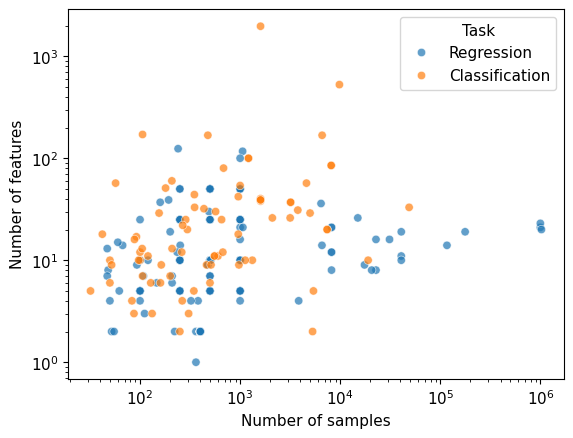

In [20]:
clf_metrics = pd.read_csv('./dataset_complexity/ds_classification_all_metrics.csv')
regr_metrics = pd.read_csv('./dataset_complexity/ds_regression_all_metrics.csv')
common_cols = clf_metrics.columns.intersection(regr_metrics.columns)
clf_metrics_comm = clf_metrics[common_cols]
regr_metrics_comm = regr_metrics[common_cols]
clf_metrics_comm.loc[:,'Task'] = 'Classification'
regr_metrics_comm.loc[:,'Task'] = 'Regression'
data_m = pd.concat([regr_metrics_comm, clf_metrics_comm], ignore_index=True)
ax = sns.scatterplot(data=data_m, x="row", y="col", hue="Task", alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of samples");
ax.set_ylabel("Number of features");

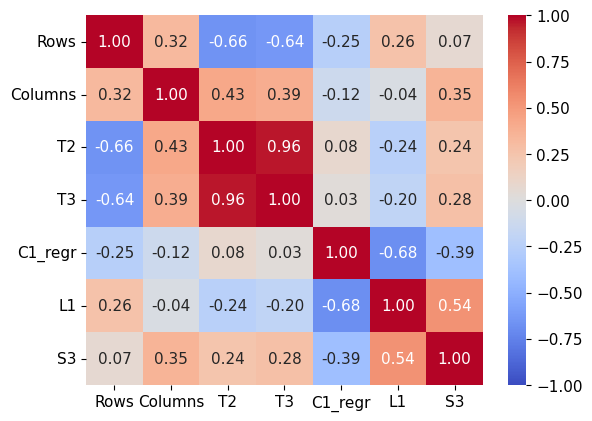

In [21]:
regr_metrics.rename(columns={"row": "Rows", "col": "Columns"}, inplace=True);
sns.heatmap(regr_metrics[["Rows","Columns","T2", "T3", "C1_regr", "L1", "S3"]].corr(method='spearman'), cmap="coolwarm", center=0,vmin=-1, vmax=1, annot=True,fmt=".2f");

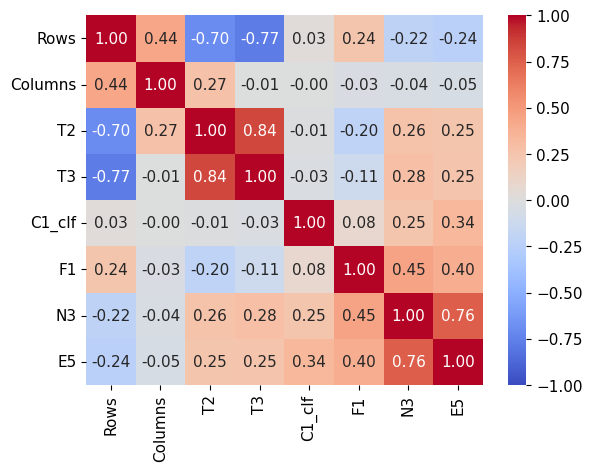

In [6]:
clf_metrics.rename(columns={"row": "Rows", "col": "Columns"}, inplace=True);
sns.heatmap(clf_metrics[["Rows","Columns","T2", "T3", "C1_clf", "F1", "N3", "E5"]].corr(method='spearman'), cmap="coolwarm", center=0,vmin=-1, vmax=1, annot=True,fmt=".2f");

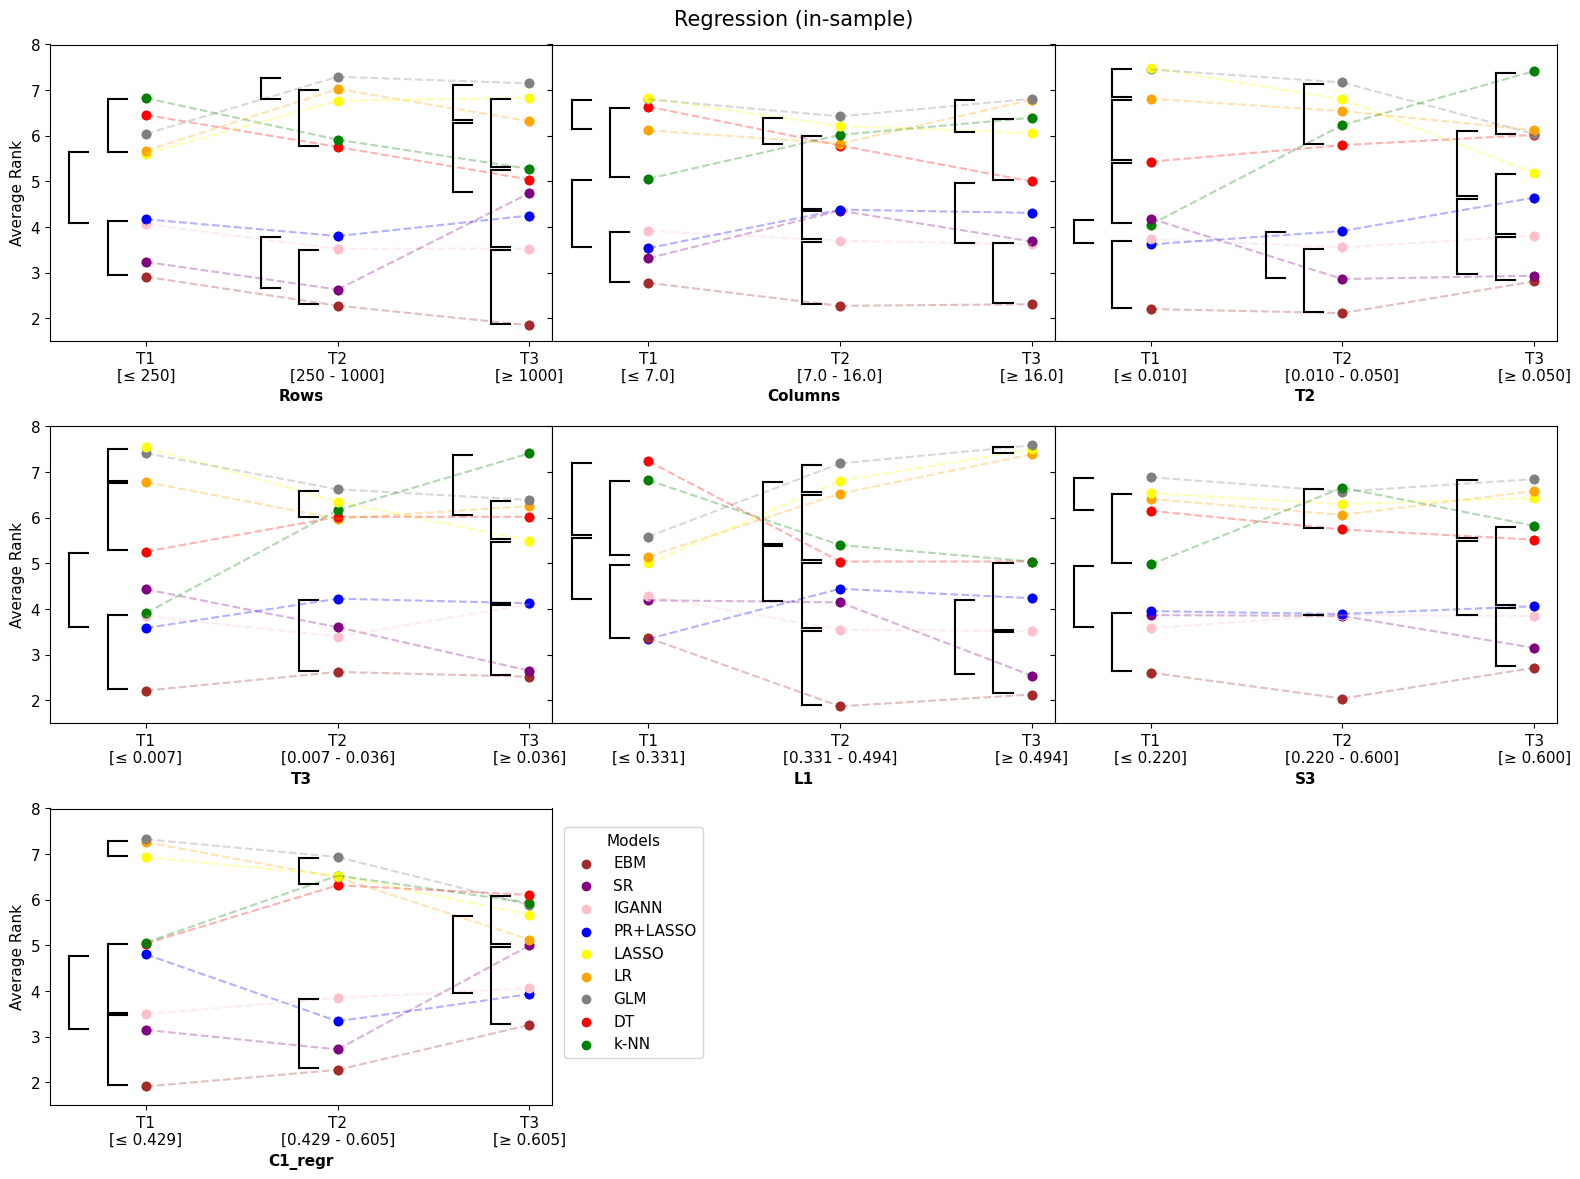

In [7]:
regr_is_res = pd.read_csv('REGR_MERGED_RESULTS_IS_MED.csv')
regr_is_res.rename(columns={"row": "Rows", "col": "Columns"}, inplace=True);
regr_ds_complexity = ["Rows","Columns", "T2","T3","L1","S3","C1_regr"]
for metr in regr_ds_complexity:
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    regr_is_res[metric] = pd.qcut(regr_is_res[metr], q=3, labels=False)
    regr_is_res[metric] = regr_is_res[metric] + 1
    regr_is_res[metric_r] = pd.qcut(-regr_is_res[metr], q=3, labels=False)
    regr_is_res[metric_r] = regr_is_res[metric_r] + 1
    regr_is_res[metric_r] = 4 - regr_is_res[metric_r]
fig, axs = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
all_handles = []
all_labels = []
prec = {"Rows":0,
        "Columns":1,
        "T2":3,
        "T3":3,
        "L1":3,
        "S3":3,
        "C1_regr":3}
for ci, metr in enumerate(regr_ds_complexity):

    ax = axs[ci//3, ci%3]
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    df = regr_is_res
    colors = {
    'decision_tree_regressor': 'red',
    'ebm': 'brown',
    'knn': 'green',
    'linear_regression': 'orange',
    'symbolic_regression': 'purple',
    'lasso':"yellow",
    'poly_lasso':"blue",
    'igann':"pink",
    'glm':"gray"
    }
    display_names = {
        'decision_tree_regressor': 'DT',
        'ebm': 'EBM',
        'knn': 'k-NN',
        'linear_regression': 'LR',
        'symbolic_regression': 'SR',
        'lasso':"LASSO",
        'poly_lasso':"PR+LASSO",
        'glm':"GLM",
        'igann':'IGANN'
    }
    # Create plot
    
    # To store previous points for each model
    prev_points = {}
    for qu in range(1,4):
        mask_q = (df[metric]==qu) | (df[metric_r]==qu)

        avg_ranks = df[mask_q].groupby('Dataset').R2.rank(ascending=False, pct=False).groupby(df.Model).mean()
        group = df[mask_q].pivot(index="Dataset", columns="Model", values="R2")

        nemenyi = sp.posthoc_nemenyi_friedman(group)
        adj_matrix = pd.DataFrame(
            1 - sp.sign_array(nemenyi, alpha=0.05),
            index=nemenyi.index,
            columns=nemenyi.columns,
            dtype=bool,
        )
        cliques = _find_maximal_cliques(adj_matrix)

        # Sort models by avg rank
        models, ranks = zip(*sorted(avg_ranks.items(), key=lambda x: x[1]))
        y = ranks


        for i, model in enumerate(models):
            ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            sc = ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            all_handles.append(sc)
            all_labels.append(display_names.get(model, model))
            if model in prev_points:
                ax.plot([prev_points[model][0], qu], [prev_points[model][1], y[i]], color=colors[model], linestyle='--', alpha=0.3)
            prev_points[model] = (qu, y[i])

        def add_bracket(ax, models, y, clique, quotas):
            clique_models = [m for m in models if m in clique]
            if len(clique_models) < 2:
                return False
            y_start = min(y[models.index(m)] for m in clique_models)+0.03
            y_end = max(y[models.index(m)] for m in clique_models)-0.03
            #x_pos = 0.3 + 0.3 * level
            level = 0
            for l,q in enumerate(quotas):
                if q < y_start:
                    
                    level = l
                    quotas[l] = y_end
                    break
                    
            x_pos = qu-0.2 + -0.2 * level

            ax.plot([x_pos, x_pos], [y_start, y_end], color='black')
            ax.plot([x_pos, x_pos + 0.1], [y_start, y_start], color='black')
            ax.plot([x_pos, x_pos + 0.1], [y_end, y_end], color='black')
            return True

        # Draw cliques (stacking them at increasing distances to the right)
        
        quotas = [0,]*5
       
        cliques = sorted(cliques, key=lambda x: min(avg_ranks[list(x)]))
        for clique in cliques:

            if add_bracket(ax, models, y, clique, quotas):
                pass


    ax.set_xlim(0.5, None)
    ax.set_xticks(range(1,4))
    bins = pd.qcut(df[metr], q=3).cat.categories
    labels = []
    for i, interval in enumerate(bins):
        left, right = interval.left, interval.right
        if i == 0:
            labels.append(f"≤ {right:.{prec[metr]}f}")
        elif i == len(bins) - 1:
            labels.append(f"≥ {left:.{prec[metr]}f}")
        else:

            labels.append(f"{left:.{prec[metr]}f} - {right:.{prec[metr]}f}")

    ax.set_xticklabels([f"T{k+1}\n[{v}]" for k, v in enumerate(labels)])

    ax.set_ylabel('Average Rank')
    if ci % 3 != 0:

        ax.set_ylabel('')
    ax.set_xlabel(metr, fontweight='bold')
    ax.set_ylim(bottom=1.5, top=8)


axs[2, 1].set_visible(False)
axs[2, 2].set_visible(False)

by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), title='Models', loc='lower center', bbox_to_anchor=(0.40, 0.10))#,fontsize='large')
fig.suptitle("Regression (in-sample)", fontsize=15)
plt.tight_layout()
plt.subplots_adjust(wspace=0.0)
#plt.savefig(f"./figures/regr_is_grid_ter.pdf", format="pdf")
plt.show()

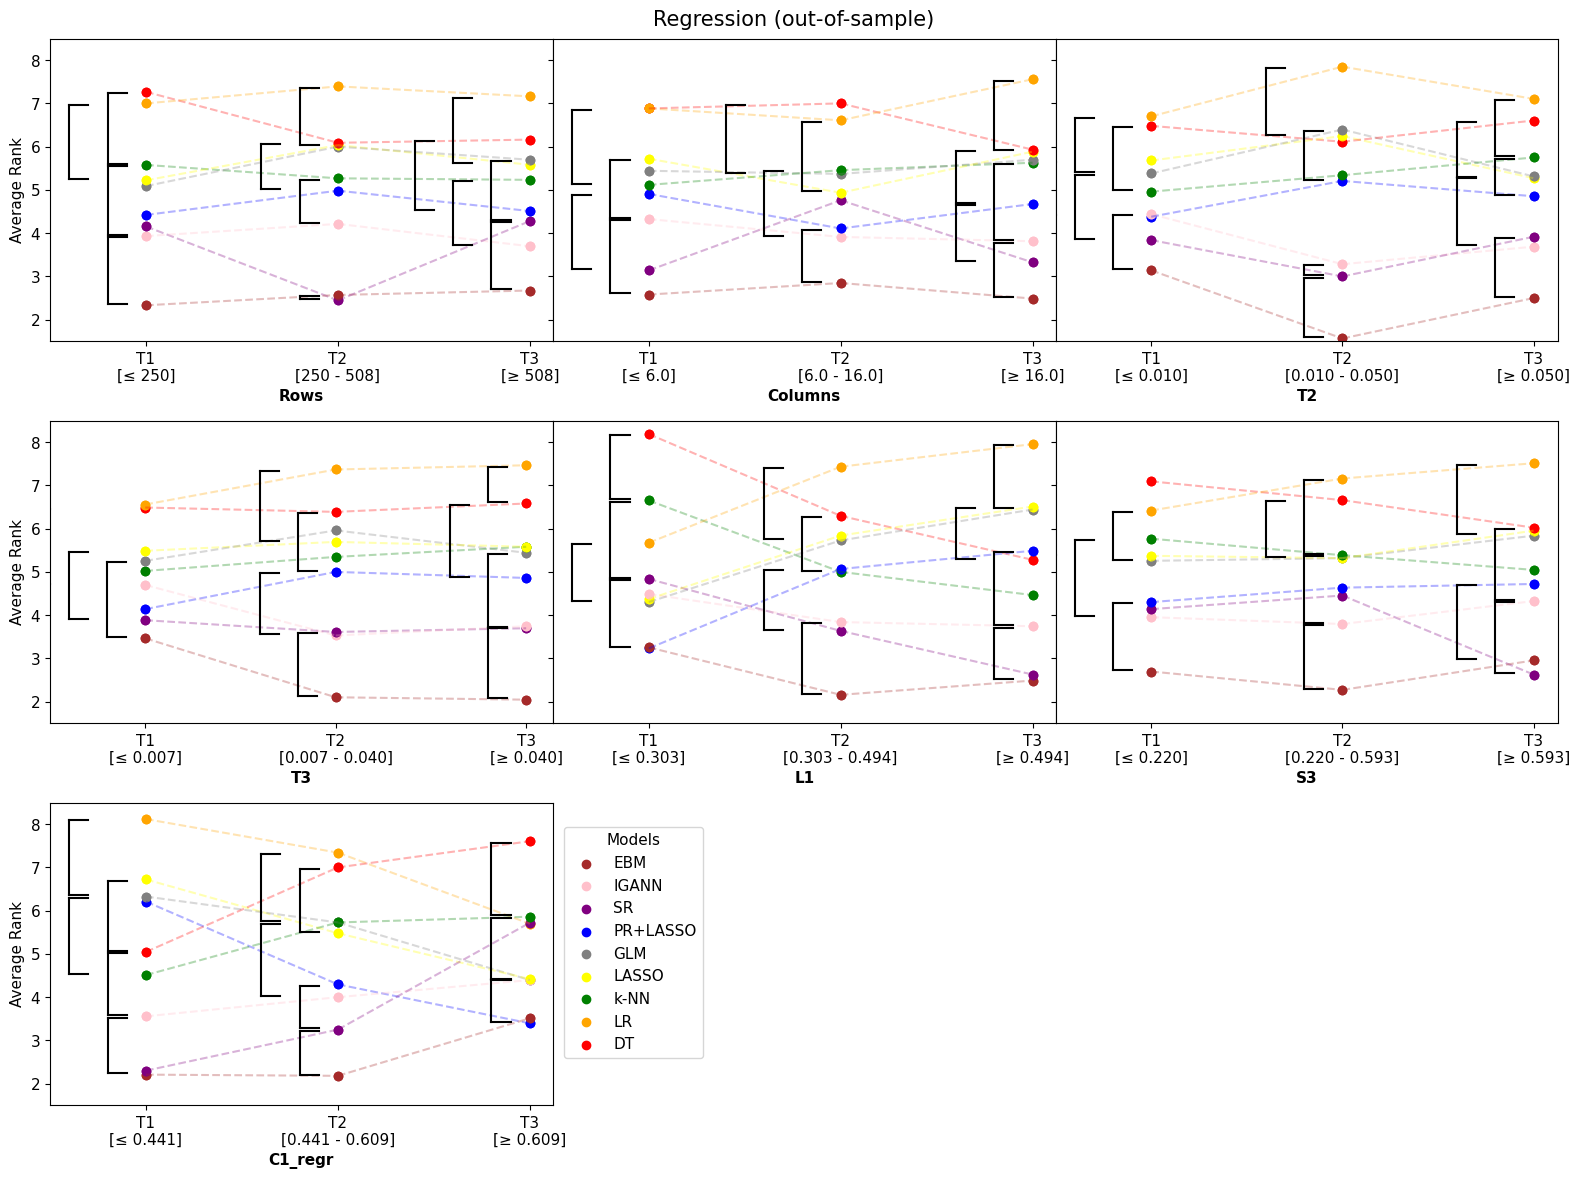

In [8]:
regr_oos_res = pd.read_csv('REGR_MERGED_RESULTS_OOS_MED.csv')
regr_oos_res.rename(columns={"row": "Rows", "col": "Columns"}, inplace=True);
regr_ds_complexity = ["Rows","Columns", "T2","T3","L1","S3","C1_regr"]
for metr in regr_ds_complexity:
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    regr_oos_res[metric] = pd.qcut(regr_oos_res[metr], q=3, labels=False)
    regr_oos_res[metric] = regr_oos_res[metric] + 1
    regr_oos_res[metric_r] = pd.qcut(-regr_oos_res[metr], q=3, labels=False)
    regr_oos_res[metric_r] = regr_oos_res[metric_r] + 1
    regr_oos_res[metric_r] = 4 - regr_oos_res[metric_r]
fig, axs = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
plt.rcParams.update({'font.size': 11})
all_handles = []
all_labels = []
prec = {"Rows":0,
        "Columns":1,
        "T2":3,
        "T3":3,
        "L1":3,
        "S3":3,
        "C1_regr":3}
for ci, metr in enumerate(regr_ds_complexity):

    ax = axs[ci//3, ci%3]
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    df = regr_oos_res
    colors = {
    'decision_tree_regressor': 'red',
    'ebm': 'brown',
    'knn': 'green',
    'linear_regression': 'orange',
    'symbolic_regression': 'purple',
    'lasso':"yellow",
    'poly_lasso':"blue",
    'igann':"pink",
    'glm':"gray"
    }
    display_names = {
        'decision_tree_regressor': 'DT',
        'ebm': 'EBM',
        'knn': 'k-NN',
        'linear_regression': 'LR',
        'symbolic_regression': 'SR',
        'lasso':"LASSO",
        'poly_lasso':"PR+LASSO",
        'glm':"GLM",
        'igann':'IGANN'
    }
    # Create plot
    
    # To store previous points for each model
    prev_points = {}
    for qu in range(1,4):
        mask_q = (df[metric]==qu) | (df[metric_r]==qu)

        avg_ranks = df[mask_q].groupby('Dataset').R2.rank(ascending=False, pct=False).groupby(df.Model).mean()
        group = df[mask_q].pivot(index="Dataset", columns="Model", values="R2")

        nemenyi = sp.posthoc_nemenyi_friedman(group)
        adj_matrix = pd.DataFrame(
            1 - sp.sign_array(nemenyi, alpha=0.05),
            index=nemenyi.index,
            columns=nemenyi.columns,
            dtype=bool,
        )
        cliques = _find_maximal_cliques(adj_matrix)

        models, ranks = zip(*sorted(avg_ranks.items(), key=lambda x: x[1]))
        y = ranks

        for i, model in enumerate(models):
            ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            sc = ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            all_handles.append(sc)
            all_labels.append(display_names.get(model, model))
            if model in prev_points:
                ax.plot([prev_points[model][0], qu], [prev_points[model][1], y[i]], color=colors[model], linestyle='--', alpha=0.3)
            prev_points[model] = (qu, y[i])

        def add_bracket(ax, models, y, clique, quotas):
            clique_models = [m for m in models if m in clique]
            if len(clique_models) < 2:
                return False
            y_start = min(y[models.index(m)] for m in clique_models)+0.03
            y_end = max(y[models.index(m)] for m in clique_models)-0.03
            #x_pos = 0.3 + 0.3 * level
            level = 0
            for l,q in enumerate(quotas):
                if q < y_start:
                    
                    level = l
                    quotas[l] = y_end
                    break
                    
            x_pos = qu-0.2 + -0.2 * level

            ax.plot([x_pos, x_pos], [y_start, y_end], color='black')
            ax.plot([x_pos, x_pos + 0.1], [y_start, y_start], color='black')
            ax.plot([x_pos, x_pos + 0.1], [y_end, y_end], color='black')
            return True

        
        quotas = [0,]*5
       
        cliques = sorted(cliques, key=lambda x: min(avg_ranks[list(x)]))
        for clique in cliques:

            if add_bracket(ax, models, y, clique, quotas):
                pass


    # Format
    ax.set_xlim(0.5, None)
    ax.set_xticks(range(1,4))
    bins = pd.qcut(df[metr], q=3).cat.categories
    labels = []
    for i, interval in enumerate(bins):
        left, right = interval.left, interval.right
        if i == 0:
            labels.append(f"≤ {right:.{prec[metr]}f}")
        elif i == len(bins) - 1:
            labels.append(f"≥ {left:.{prec[metr]}f}")
        else:
            #labels.append(f"{left:.0f} ≤ x < {right:.0f}")
            labels.append(f"{left:.{prec[metr]}f} - {right:.{prec[metr]}f}")

    ax.set_xticklabels([f"T{k+1}\n[{v}]" for k, v in enumerate(labels)])

    ax.set_ylabel('Average Rank')
    if ci % 3 != 0:
        ax.set_ylabel('')
    ax.set_xlabel(metr, fontweight='bold')
    ax.set_ylim(bottom=1.5, top=8.5)


axs[2, 1].set_visible(False)
axs[2, 2].set_visible(False)

by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), title='Models', loc='lower center', bbox_to_anchor=(0.40, 0.10))#,fontsize='large')
fig.suptitle("Regression (out-of-sample)", fontsize=15)
plt.tight_layout()
plt.subplots_adjust(wspace=0.0)
#plt.savefig(f"./figures/regr_oos_grid_ter.pdf", format="pdf")
plt.show()

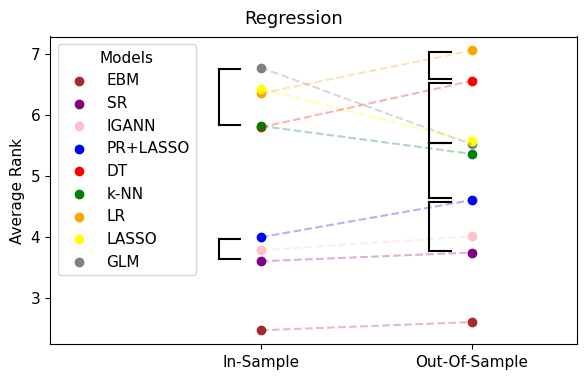

In [9]:
df = regr_is_res
plt.rcParams.update({'font.size': 11})
colors = {
'decision_tree_regressor': 'red',
'ebm': 'brown',
'knn': 'green',
'linear_regression': 'orange',
'symbolic_regression': 'purple',
'lasso':"yellow",
'poly_lasso':"blue",
'igann':"pink",
'glm':"gray"
}
display_names = {
    'decision_tree_regressor': 'DT',
    'ebm': 'EBM',
    'knn': 'k-NN',
    'linear_regression': 'LR',
    'symbolic_regression': 'SR',
    'lasso':"LASSO",
    'poly_lasso':"PR+LASSO",
    'glm':"GLM",
    'igann':'IGANN'
}

# Create plot
fig, ax = plt.subplots(figsize=(6, 4))
# To store previous points for each model
prev_points = {}
for qu, df in enumerate([regr_is_res, regr_oos_res], start=1):
    avg_ranks = df.groupby('Dataset').R2.rank(ascending=False, pct=False).groupby(df.Model).mean()
    group = df.pivot(index="Dataset", columns="Model", values="R2")
    nemenyi = sp.posthoc_nemenyi_friedman(group)
    adj_matrix = pd.DataFrame(
        1 - sp.sign_array(nemenyi, alpha=0.05),
        index=nemenyi.index,
        columns=nemenyi.columns,
        dtype=bool,
    )
    cliques = _find_maximal_cliques(adj_matrix)

    # Sort models by avg rank
    models, ranks = zip(*sorted(avg_ranks.items(), key=lambda x: x[1]))
    y = ranks


    for i, model in enumerate(models):
        ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
        if model in prev_points:
            ax.plot([prev_points[model][0], qu], [prev_points[model][1], y[i]], color=colors[model], linestyle='--', alpha=0.3)
        prev_points[model] = (qu, y[i])

    def add_bracket(ax, models, y, clique, quotas):
        clique_models = [m for m in models if m in clique]
        if len(clique_models) < 2:
            return False
        y_start = min(y[models.index(m)] for m in clique_models)+0.03
        y_end = max(y[models.index(m)] for m in clique_models)-0.03
        #x_pos = 0.3 + 0.3 * level
        level = 0
        for l,q in enumerate(quotas):
            if q < y_start:

                level = l
                quotas[l] = y_end
                break

        x_pos = qu-0.2 + -0.2 * level

        ax.plot([x_pos, x_pos], [y_start, y_end], color='black')
        ax.plot([x_pos, x_pos + 0.1], [y_start, y_start], color='black')
        ax.plot([x_pos, x_pos + 0.1], [y_end, y_end], color='black')
        return True


    quotas = [0,]*5

    cliques = sorted(cliques, key=lambda x: min(avg_ranks[list(x)]))
    for clique in cliques:

        if add_bracket(ax, models, y, clique, quotas):
            pass

# Format
ax.set_xlim(0, 2.5)
ax.set_xticks(range(1,3))
ax.set_xticklabels(['In-Sample', 'Out-Of-Sample'])

ax.set_ylabel('Average Rank')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Models',loc='upper left')
fig.suptitle("Regression",y=0.94, fontsize=13)

plt.tight_layout()
#plt.savefig(f"./figures/regr_is_vs_os.pdf", format="pdf")
plt.show()

In [10]:
duration_regr = regr_is_res.copy() 


/tmp/ipykernel_1756746/1671443538.py:26: UserWarning: 
The palette list has fewer values (8) than needed (9) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(
/tmp/ipykernel_1756746/1671443538.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([display_names[m] for m in order])


[Text(0, 0, 'DT'),
 Text(1, 0, 'EBM'),
 Text(2, 0, 'GLM'),
 Text(3, 0, 'IGANN'),
 Text(4, 0, 'k-NN'),
 Text(5, 0, 'LASSO'),
 Text(6, 0, 'LR'),
 Text(7, 0, 'PR+LASSO')]

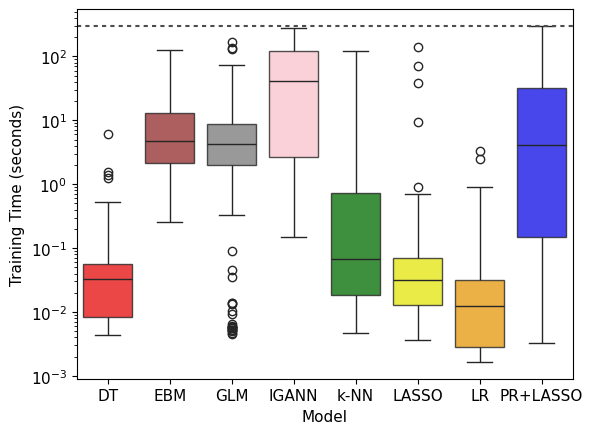

In [11]:
order = duration_regr["Model"].unique().tolist()
order.remove("symbolic_regression")

colors = {
'decision_tree_regressor': 'red',
'ebm': 'brown',
'knn': 'green',
'linear_regression': 'orange',
'symbolic_regression': 'purple',
'lasso':"yellow",
'poly_lasso':"blue",
'igann':"pink",
'glm':"gray"
}
display_names = {
    'decision_tree_regressor': 'DT',
    'ebm': 'EBM',
    'knn': 'k-NN',
    'linear_regression': 'LR',
    'symbolic_regression': 'SR',
    'lasso':"LASSO",
    'poly_lasso':"PR+LASSO",
    'glm':"GLM",
    'igann':'IGANN'
}
ax = sns.boxplot(
    data=duration_regr,
    x="Model",
    y="Duration",
    order=order,
    log_scale=True,
    palette=[colors[m] for m in order],  # set colors based on order
    hue="Model",
    legend=False,
    saturation=0.8,
    boxprops=dict(alpha=.8)
)
ax.axhline(300, color=".3", dashes=(2, 2))
ax.set_ylabel("Training Time (seconds)")

# Change tick labels to display names
ax.set_xticklabels([display_names[m] for m in order])

#plt.savefig(f"./figures/training_time_regr.pdf", format="pdf")

/tmp/ipykernel_1756746/4208457037.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


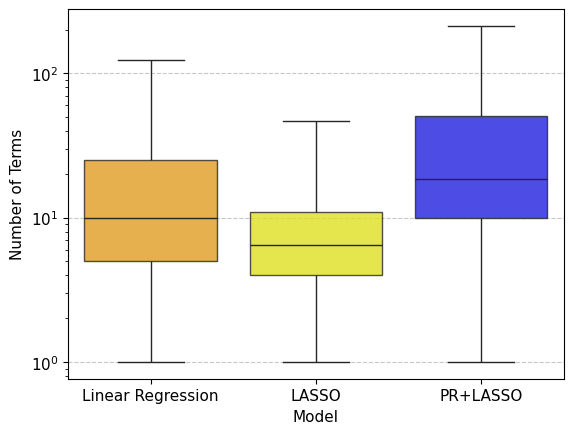

In [12]:
plt.rcParams.update({'font.size': 11})

plot_df = regr_is_res.copy()

plot_df.loc[plot_df['Model'] == "lasso", 'Model'] = "LASSO"
plot_df.loc[plot_df['Model'] == "poly_lasso", 'Model'] = "PR+LASSO"
plot_df.loc[plot_df['Model'] == "linear_regression", 'Model'] = "Linear_Regression"

order = ["Linear_Regression", "LASSO", "PR+LASSO"]

x_labels = ["Linear Regression", "LASSO", "PR+LASSO"]

#plt.figure(figsize=(10, 6))
colors = {
'decision_tree_regressor': 'red',
'ebm': 'brown',
'knn': 'green',
'Linear_Regression': 'orange',
'symbolic_regression': 'purple',
'PR+LASSO':"blue",
'LASSO':"yellow",
'igann':"pink",
'glm':"gray"
}

ax = sns.boxplot(
    data=plot_df, 
    x="Model", 
    y="complexity", 
    order=order, 
    log_scale=True, # Set to True if the scale is too wide for visualization
    palette=colors,  # set colors based on order
    hue="Model",
    legend=False,
    saturation=0.75,
    boxprops=dict(alpha=.8)
)

ax.set_xticklabels(x_labels)

ax.set_ylabel("Number of Terms")

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
#plt.savefig(f"./figures/number_of_lin_terms_nonlog.pdf", format="pdf")
#plt.savefig(f"./figures/number_of_lin_terms.pdf", format="pdf")
plt.show()


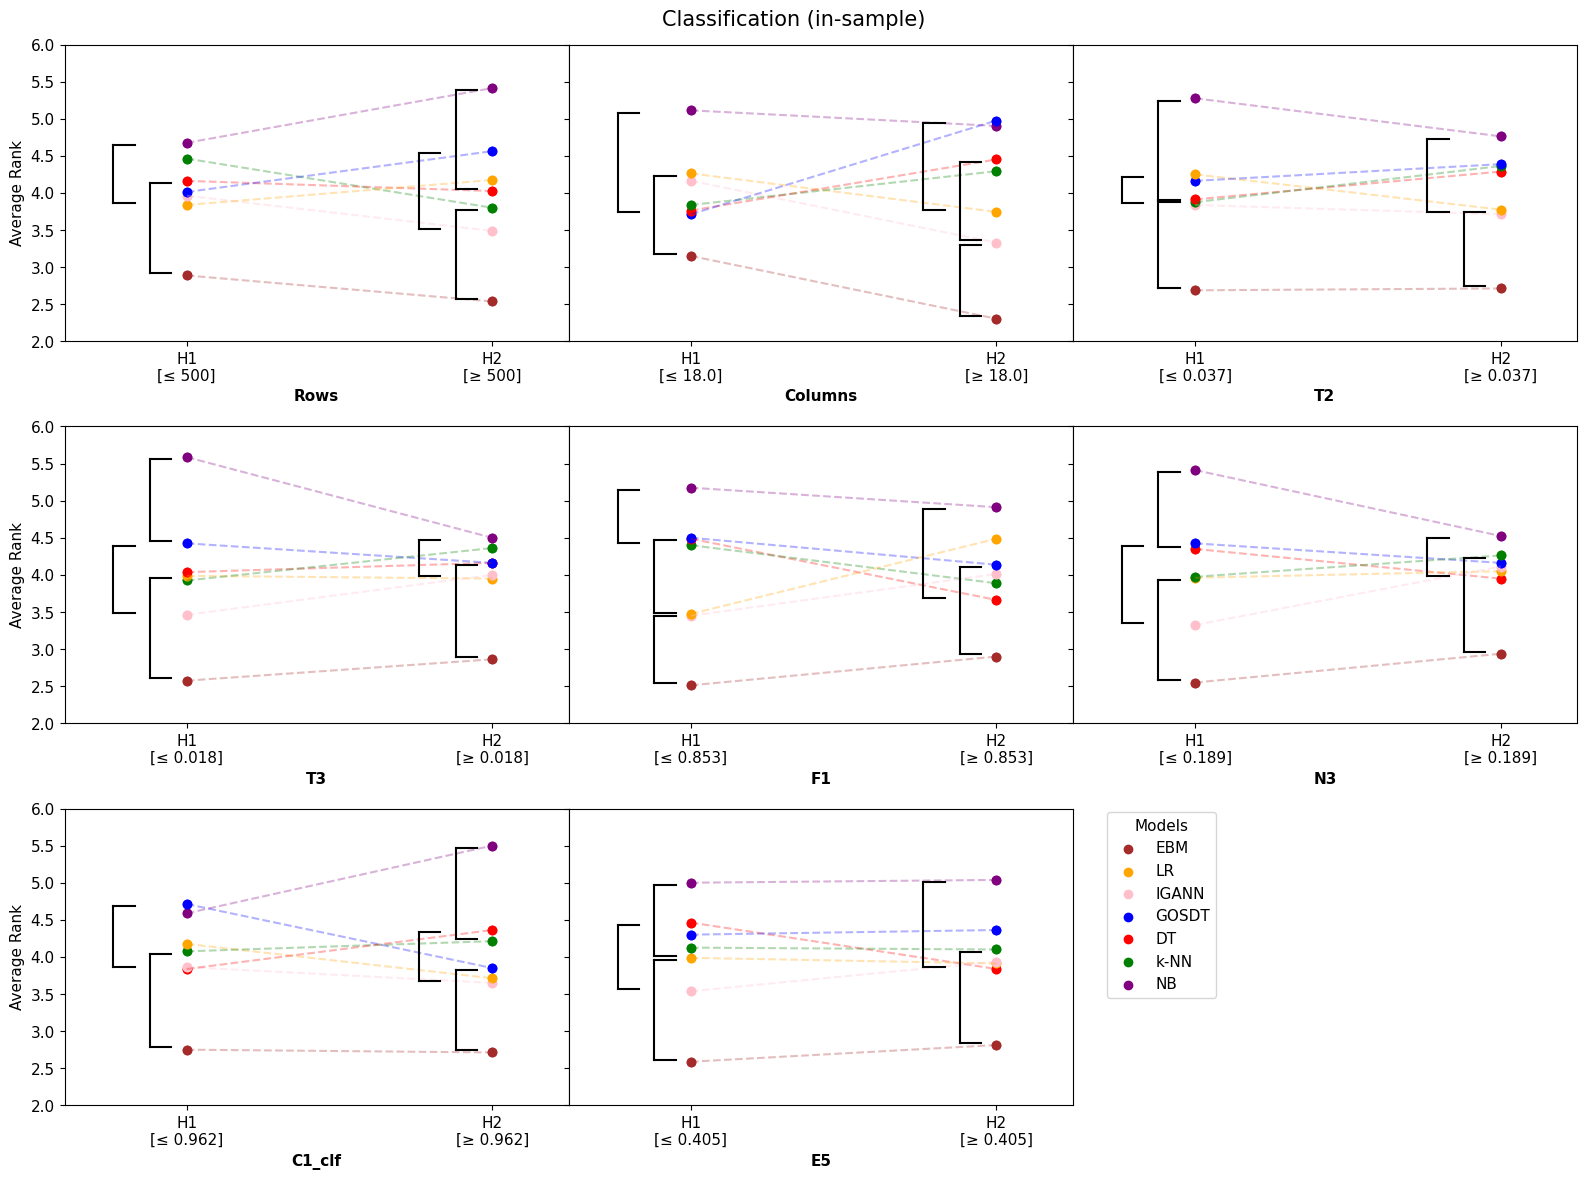

In [13]:
clf_is_res = pd.read_csv('CLF_MERGED_RESULTS_IS_MED.csv')
clf_ds_complexity = ["Rows", "Columns", "T2","T3","F1","N3","C1_clf", "E3", "E5"]
clf_is_res.rename(columns={"row": "Rows", "col": "Columns"}, inplace=True);

for metr in clf_ds_complexity:
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    clf_is_res[metric] = pd.qcut(clf_is_res[metr], q=4, labels=False)
    clf_is_res[metric] = clf_is_res[metric] + 1
    clf_is_res[metric_r] = pd.qcut(-clf_is_res[metr], q=4, labels=False)
    clf_is_res[metric_r] = clf_is_res[metric_r] + 1
    clf_is_res[metric_r] = 5 - clf_is_res[metric_r]

fig, axs = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
plt.rcParams.update({'font.size': 11})
all_handles = []
all_labels = []
clf_ds_complexity_print = ["Rows", "Columns", "T2","T3","F1","N3","C1_clf", "E5"]
prec = {"Rows":0,
        "Columns":1,
        "T2":3,
        "T3":3,
        "F1":3,
        "N3":3,
        "C1_clf":3,
        "E3":3,
        "E5":3,}
for ci, metr in enumerate(clf_ds_complexity_print):

    ax = axs[ci//3, ci%3]
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    df = clf_is_res
    colors = {
    'decision_tree': 'red',
    'gosdt': 'blue',
    'knn': 'green',
    'logistic_regression': 'orange',
    'naive_bayes': 'purple',
    'ebm':"brown",
    'igann':"pink"
    }
    display_names = {
        'decision_tree': 'DT',
        'gosdt': 'GOSDT',
        'knn': 'k-NN',
        'logistic_regression': 'LR',
        'naive_bayes': 'NB',
        'ebm':"EBM",
        'igann':"IGANN"
    }
    # Create plot
    
    # To store previous points for each model
    prev_points = {}
    for qu in range(1,3):
        if qu==1:
            mask_q = (df[metric]<=2) | (df[metric_r]==2)
        elif qu==2:
            mask_q = (df[metric]>=3) | (df[metric_r]==3)
        else:
            pass
        avg_ranks = df[mask_q].groupby('Dataset').Fbeta.rank(ascending=False, pct=False).groupby(df.Model).mean()
        group = df[mask_q].pivot(index="Dataset", columns="Model", values="Fbeta")        
        nemenyi = sp.posthoc_nemenyi_friedman(group)
        adj_matrix = pd.DataFrame(
            1 - sp.sign_array(nemenyi, alpha=0.05),
            index=nemenyi.index,
            columns=nemenyi.columns,
            dtype=bool,
        )
        cliques = _find_maximal_cliques(adj_matrix)

        # Sort models by avg rank
        models, ranks = zip(*sorted(avg_ranks.items(), key=lambda x: x[1]))

        y = ranks


        for i, model in enumerate(models):
            ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            sc = ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            all_handles.append(sc)
            all_labels.append(display_names.get(model, model))
            if model in prev_points:
                ax.plot([prev_points[model][0], qu], [prev_points[model][1], y[i]], color=colors[model], linestyle='--', alpha=0.3)
            prev_points[model] = (qu, y[i])

        def add_bracket(ax, models, y, clique, quotas):
            clique_models = [m for m in models if m in clique]
            if len(clique_models) < 2:
                return False
            y_start = min(y[models.index(m)] for m in clique_models)+0.03
            y_end = max(y[models.index(m)] for m in clique_models)-0.03
            #x_pos = 0.3 + 0.3 * level
            level = 0
            for l,q in enumerate(quotas):
                if q < y_start:
                    
                    level = l
                    quotas[l] = y_end
                    break
                    
            x_pos = qu-0.12 + -0.12 * level

            ax.plot([x_pos, x_pos], [y_start, y_end], color='black')
            ax.plot([x_pos, x_pos + 0.07], [y_start, y_start], color='black')
            ax.plot([x_pos, x_pos + 0.07], [y_end, y_end], color='black')
            return True

        # Draw cliques (stacking them at increasing distances to the right)
        
        quotas = [0,]*5
       
        cliques = sorted(cliques, key=lambda x: min(avg_ranks[list(x)]))
        for clique in cliques:

            if add_bracket(ax, models, y, clique, quotas):
                pass


    # Format
    ax.set_xlim(0.6, 2.25)
    ax.set_xticks(range(1,3))
    bins = pd.qcut(df[metr], q=2).cat.categories
    #print(bins)
    labels = []
    for i, interval in enumerate(bins):
        left, right = interval.left, interval.right
        if i == 0:
            labels.append(f"≤ {right:.{prec[metr]}f}")
        elif i == len(bins) - 1:
            labels.append(f"≥ {left:.{prec[metr]}f}")
        else:
            #labels.append(f"{left:.0f} ≤ x < {right:.0f}")
            labels.append(f"{left:.{prec[metr]}f} - {right:.{prec[metr]}f}")

    ax.set_xticklabels([f"H{k+1}\n[{v}]" for k, v in enumerate(labels)])

    ax.set_ylabel('Average Rank')
    if ci % 3 != 0:
        ax.set_ylabel('')
    ax.set_xlabel(metr, fontweight='bold')
    ax.set_ylim(bottom=2, top=6)



axs[2, 2].set_visible(False)

by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), title='Models', loc='lower center', bbox_to_anchor=(0.73, 0.15))#,fontsize='large')
fig.suptitle("Classification (in-sample)", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.0)

#plt.savefig(f"./figures/clf_is_grid_halves.pdf", format="pdf")
plt.show()


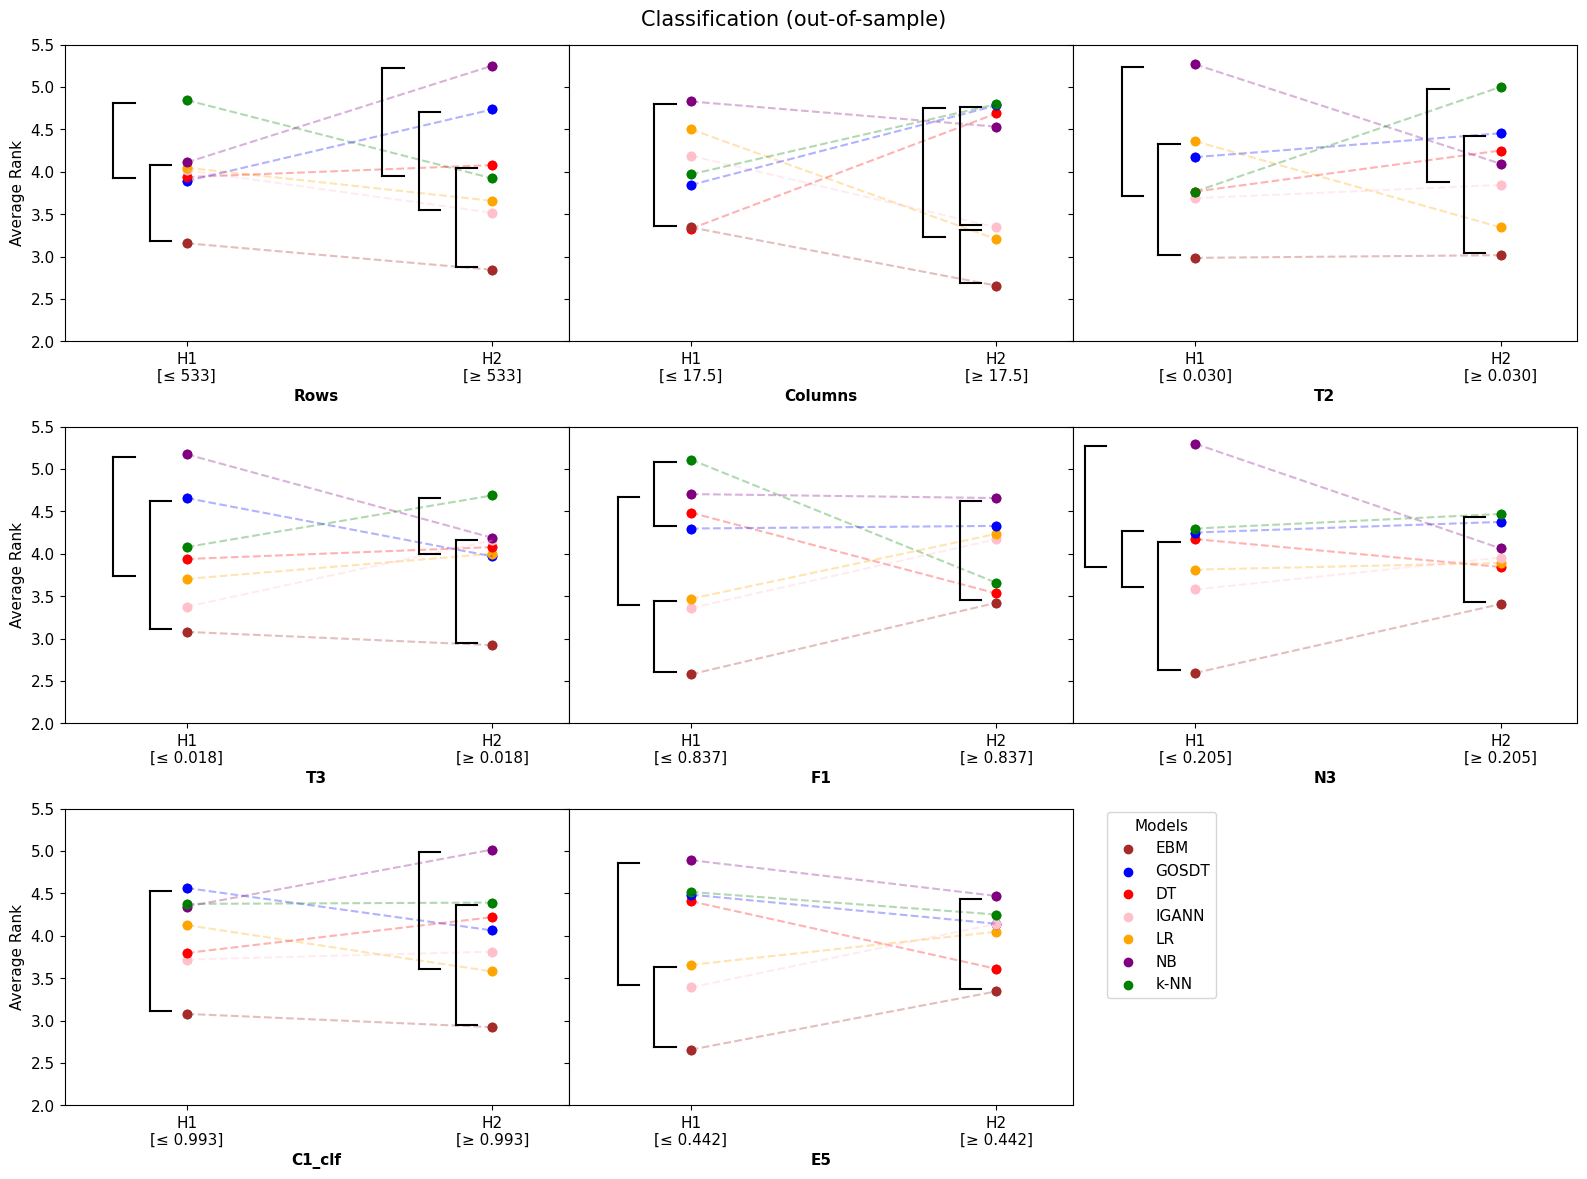

In [14]:
clf_oos_res = pd.read_csv('CLF_MERGED_RESULTS_OOS_MED.csv')
clf_ds_complexity = ["Rows", "Columns", "T2","T3","F1","N3","C1_clf", "E3", "E5"]
clf_oos_res.rename(columns={"row": "Rows", "col": "Columns"}, inplace=True);

for metr in clf_ds_complexity:
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    clf_oos_res[metric] = pd.qcut(clf_oos_res[metr], q=4, labels=False)
    clf_oos_res[metric] = clf_oos_res[metric] + 1
    clf_oos_res[metric_r] = pd.qcut(-clf_oos_res[metr], q=4, labels=False)
    clf_oos_res[metric_r] = clf_oos_res[metric_r] + 1
    clf_oos_res[metric_r] = 5 - clf_oos_res[metric_r]
fig, axs = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
plt.rcParams.update({'font.size': 11})
all_handles = []
all_labels = []
clf_ds_complexity_print = ["Rows", "Columns", "T2","T3","F1","N3","C1_clf", "E5"]
prec = {"Rows":0,
        "Columns":1,
        "T2":3,
        "T3":3,
        "F1":3,
        "N3":3,
        "C1_clf":3,
        "E3":3,
        "E5":3,}
for ci, metr in enumerate(clf_ds_complexity_print):

    ax = axs[ci//3, ci%3]
    metric=metr+"_decile"
    metric_r=metr+"_decile_r"
    df = clf_oos_res
    colors = {
    'decision_tree': 'red',
    'gosdt': 'blue',
    'knn': 'green',
    'logistic_regression': 'orange',
    'naive_bayes': 'purple',
    'ebm':"brown",
    'igann':"pink"
    }
    display_names = {
        'decision_tree': 'DT',
        'gosdt': 'GOSDT',
        'knn': 'k-NN',
        'logistic_regression': 'LR',
        'naive_bayes': 'NB',
        'ebm':"EBM",
        'igann':"IGANN"
    }
    # Create plot
    
    # To store previous points for each model
    prev_points = {}
    for qu in range(1,3):
        if qu==1:
            mask_q = (df[metric]<=2) | (df[metric_r]==2)
        elif qu==2:
            mask_q = (df[metric]>=3) | (df[metric_r]==3)
        else:
            pass
        avg_ranks = df[mask_q].groupby('Dataset').Fbeta.rank(ascending=False, pct=False).groupby(df.Model).mean()
        group = df[mask_q].pivot(index="Dataset", columns="Model", values="Fbeta")

        nemenyi = sp.posthoc_nemenyi_friedman(group)
        adj_matrix = pd.DataFrame(
            1 - sp.sign_array(nemenyi, alpha=0.05),
            index=nemenyi.index,
            columns=nemenyi.columns,
            dtype=bool,
        )
        cliques = _find_maximal_cliques(adj_matrix)

        # Sort models by avg rank
        models, ranks = zip(*sorted(avg_ranks.items(), key=lambda x: x[1]))

        y = ranks


        for i, model in enumerate(models):
            ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            sc = ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
            all_handles.append(sc)
            all_labels.append(display_names.get(model, model))
            if model in prev_points:
                ax.plot([prev_points[model][0], qu], [prev_points[model][1], y[i]], color=colors[model], linestyle='--', alpha=0.3)
            prev_points[model] = (qu, y[i])

        def add_bracket(ax, models, y, clique, quotas):
            clique_models = [m for m in models if m in clique]
            if len(clique_models) < 2:
                return False
            y_start = min(y[models.index(m)] for m in clique_models)+0.03
            y_end = max(y[models.index(m)] for m in clique_models)-0.03
            #x_pos = 0.3 + 0.3 * level
            level = 0
            for l,q in enumerate(quotas):
                if q < y_start:
                    
                    level = l
                    quotas[l] = y_end
                    break
                    
            x_pos = qu-0.12 + -0.12 * level

            ax.plot([x_pos, x_pos], [y_start, y_end], color='black')
            ax.plot([x_pos, x_pos + 0.07], [y_start, y_start], color='black')
            ax.plot([x_pos, x_pos + 0.07], [y_end, y_end], color='black')
            return True

        # Draw cliques (stacking them at increasing distances to the right)
        
        quotas = [0,]*5
       
        cliques = sorted(cliques, key=lambda x: min(avg_ranks[list(x)]))
        for clique in cliques:

            if add_bracket(ax, models, y, clique, quotas):
                pass


    # Format
    ax.set_xlim(0.6, 2.25)
    ax.set_xticks(range(1,3))
    bins = pd.qcut(df[metr], q=2).cat.categories
    #print(bins)
    labels = []
    for i, interval in enumerate(bins):
        left, right = interval.left, interval.right
        if i == 0:
            labels.append(f"≤ {right:.{prec[metr]}f}")
        elif i == len(bins) - 1:
            labels.append(f"≥ {left:.{prec[metr]}f}")
        else:
            #labels.append(f"{left:.0f} ≤ x < {right:.0f}")
            labels.append(f"{left:.{prec[metr]}f} - {right:.{prec[metr]}f}")

    ax.set_xticklabels([f"H{k+1}\n[{v}]" for k, v in enumerate(labels)])

    ax.set_ylabel('Average Rank')
    if ci % 3 != 0:
        # Hide y-axis labels for all but the first column
        ax.set_ylabel('')
    ax.set_xlabel(metr, fontweight='bold')
    ax.set_ylim(bottom=2, top=5.5)



axs[2, 2].set_visible(False)

by_label = dict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(), title='Models', loc='lower center', bbox_to_anchor=(0.73, 0.15))#,fontsize='large')
fig.suptitle("Classification (out-of-sample)", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.0)

#plt.savefig(f"./figures/clf_oos_grid_halves.pdf", format="pdf")
plt.show()

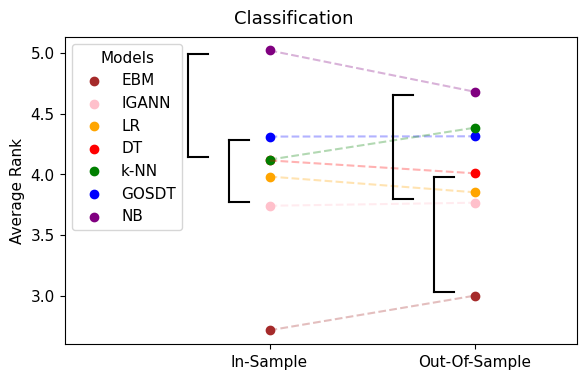

In [15]:
plt.rcParams.update({'font.size': 11})

metric=metr
metric_r=metr
df = clf_oos_res
colors = {
'decision_tree': 'red',
'gosdt': 'blue',
'knn': 'green',
'logistic_regression': 'orange',
'naive_bayes': 'purple',
'ebm':"brown",
'igann':"pink"
}
display_names = {
    'decision_tree': 'DT',
    'gosdt': 'GOSDT',
    'knn': 'k-NN',
    'logistic_regression': 'LR',
    'naive_bayes': 'NB',
    'ebm':"EBM",
    'igann':"IGANN"
}
# Create plot
fig, ax = plt.subplots(figsize=(6, 4))
# To store previous points for each model
prev_points = {}
for qu, df in enumerate([clf_is_res, clf_oos_res], start=1):
    avg_ranks = df.groupby('Dataset').Fbeta.rank(ascending=False, pct=False).groupby(df.Model).mean()
    group = df.pivot(index="Dataset", columns="Model", values="Fbeta")
    nemenyi = sp.posthoc_nemenyi_friedman(group)
    adj_matrix = pd.DataFrame(
        1 - sp.sign_array(nemenyi, alpha=0.05),
        index=nemenyi.index,
        columns=nemenyi.columns,
        dtype=bool,
    )
    cliques = _find_maximal_cliques(adj_matrix)

    # Sort models by avg rank
    models, ranks = zip(*sorted(avg_ranks.items(), key=lambda x: x[1]))
    #y = np.arange(len(models))  # positions
    y = ranks

    #ax.scatter(np.zeros_like(y), y)
    for i, model in enumerate(models):
        ax.scatter(qu, y[i], color=colors[model], label=display_names.get(model, model))
        if model in prev_points:
            ax.plot([prev_points[model][0], qu], [prev_points[model][1], y[i]], color=colors[model], linestyle='--', alpha=0.3)
        prev_points[model] = (qu, y[i])


    # Function to add a bracket for a clique
    def add_bracket(ax, models, y, clique, quotas):
        clique_models = [m for m in models if m in clique]
        if len(clique_models) < 2:
            return False
        y_start = min(y[models.index(m)] for m in clique_models)+0.03
        y_end = max(y[models.index(m)] for m in clique_models)-0.03
        #x_pos = 0.3 + 0.3 * level
        level = 0
        for l,q in enumerate(quotas):
            if q < y_start:

                level = l
                quotas[l] = y_end
                break

        x_pos = qu-0.2 + -0.2 * level

        ax.plot([x_pos, x_pos], [y_start, y_end], color='black')
        ax.plot([x_pos, x_pos + 0.1], [y_start, y_start], color='black')
        ax.plot([x_pos, x_pos + 0.1], [y_end, y_end], color='black')
        return True

    quotas = [0,]*5

    cliques = sorted(cliques, key=lambda x: min(avg_ranks[list(x)]))
    for clique in cliques:

        if add_bracket(ax, models, y, clique, quotas):
            pass

# Format
ax.set_xlim(0, 2.5)
ax.set_xticks(range(1,3))
ax.set_xticklabels(['In-Sample', 'Out-Of-Sample'])

ax.set_ylabel('Average Rank')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Models',loc='upper left')
fig.suptitle("Classification",y=0.94, fontsize=13)
plt.tight_layout()
#plt.savefig(f"./figures/clf_is_vs_os.pdf", format="pdf")
plt.show()

/tmp/ipykernel_1756746/2816469392.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([display_names[m] for m in order])


[Text(0, 0, 'DT'),
 Text(1, 0, 'EBM'),
 Text(2, 0, 'GOSDT'),
 Text(3, 0, 'IGANN'),
 Text(4, 0, 'k-NN'),
 Text(5, 0, 'LR'),
 Text(6, 0, 'NB')]

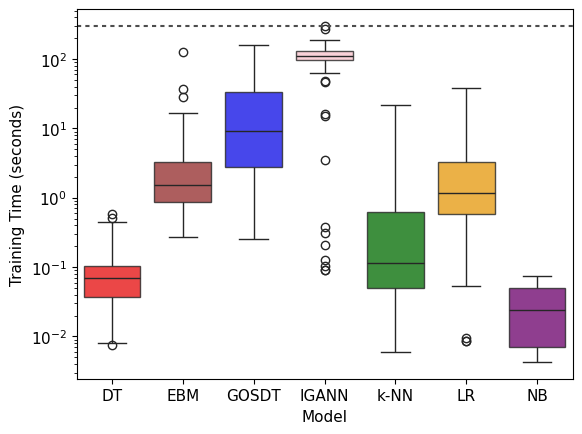

In [16]:
duration_clf = clf_is_res.copy() 

order = duration_clf["Model"].unique().tolist()

colors = {
'decision_tree': 'red',
'gosdt': 'blue',
'knn': 'green',
'logistic_regression': 'orange',
'naive_bayes': 'purple',
'ebm':"brown",
'igann':"pink"
}
display_names = {
    'decision_tree': 'DT',
    'gosdt': 'GOSDT',
    'knn': 'k-NN',
    'logistic_regression': 'LR',
    'naive_bayes': 'NB',
    'ebm':"EBM",
    'igann':"IGANN"
}
ax = sns.boxplot(
    data=duration_clf,
    x="Model",
    y="Duration",
    order=order,
    log_scale=True,
    palette=[colors[m] for m in order],  # set colors based on order
    hue="Model",
    legend=False,
    saturation=0.8,
    boxprops=dict(alpha=.8)
)
ax.axhline(300, color=".3", dashes=(2, 2))
ax.set_ylabel("Training Time (seconds)")

# Change tick labels to display names
ax.set_xticklabels([display_names[m] for m in order])
#plt.savefig(f"./figures/training_time_clf.pdf", format="pdf")

/tmp/ipykernel_1756746/3184328304.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=clf_com_is, x="Model", y="complexity",order=order,
/tmp/ipykernel_1756746/3184328304.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Decision Trees", "GOSDT"])


Text(0, 0.5, 'Tree Size')

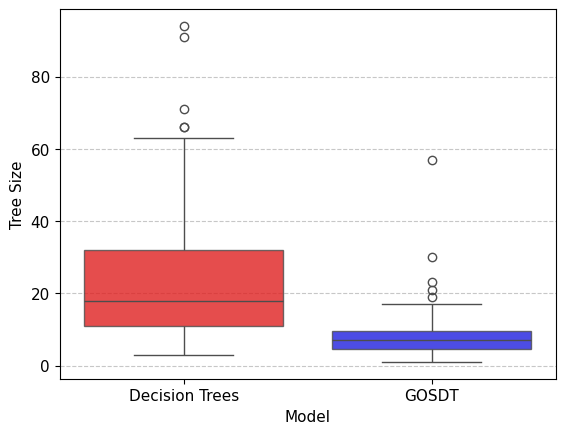

In [17]:
colors = {
'decision_tree': 'red',
'gosdt': 'blue',
'knn': 'green',
'logistic_regression': 'orange',
'naive_bayes': 'purple',
'ebm':"brown",
'igann':"pink"
}

clf_com_is = clf_is_res[clf_is_res["Model"].isin(["gosdt", "decision_tree"])]
order = ["decision_tree", "gosdt",]
ax = sns.boxplot(data=clf_com_is, x="Model", y="complexity",order=order,
                 palette=[colors[m] for m in order], log_scale=False,
                saturation=0.75,
                boxprops=dict(alpha=.8))
ax.set_xticklabels(["Decision Trees", "GOSDT"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylabel("Tree Size")
#plt.savefig(f"./figures/gosdt_dt.pdf", format="pdf")